# 1 Introducción

El siguiente código genera una nueva imagen a partir de otra especificada por parámetro. La imagen procesada es rotada (-90º y espejada) y construida únicamente con el componente RGB seleccionado por parámetro. Se busca comparar y analizar la performance del procesamiento de estructuras de dos dimensiones en GPU y en CPU.

---
# 2 Armado del ambiente
Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

In [ ]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
!wget {url_imagen} -O imagen.jpg



--2020-11-22 19:51:33--  https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg [following]
--2020-11-22 19:51:33--  https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg [following]
--2020-11-22 19:51:33--  https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147032 (144K) [image/jpeg]


---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [ ]:
!pip install pycuda

---
# 3 Desarrollo
Ejecución del algoritmo en GPU.

Imagen del filtro: imagen.jpg - RGB - [1024, 768]
Hilo: [ 16 , 19  ], Bloque : [ 48 , 54 ]
Total de hilos: [ 768 , 1026  ]  =  787968
Tiempo TOTAL:  66.509 [ms]
Tiempo GPU  :  0.175 [ms]


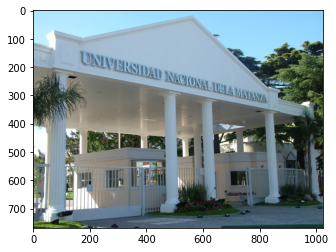

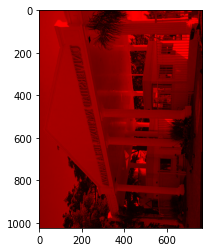

In [13]:
#@title ## 3.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique el filtro de color que desea:
color = 'Rojo' #@param ["Rojo", "Verde", "Azul"]
#@markdown ---

%matplotlib inline
from datetime import datetime
from pycuda.compiler import SourceModule
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
import matplotlib.pyplot as plt
import numpy

#Inicia tiempo total de ejecución
tiempo_total = datetime.now()

#Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

#Setea la imagen a procesar
img_nombre = 'imagen.jpg'
image = Image.open(img_nombre) 
  
#Obtiene las dimensiones de la imagen
img_ancho, img_alto = image.size 

#Convierte la imagen comprimida en JPEG/PNG a array
img_origen_cpu = numpy.asarray(image)

#Crea una nueva imagen con las dimensiones invertidas
img_dimension = Image.new(mode = "RGB", size = (img_alto, img_ancho))
img_resultado_cpu = numpy.empty_like(img_dimension)

#Reserva los 2 vectores en GPU (3 pixeles usa RGB * (el tamaño del array))
img_origen_gpu = cuda.mem_alloc(img_origen_cpu.nbytes)
img_resultado_gpu = cuda.mem_alloc(img_resultado_cpu.nbytes)

#Copia la memoria al GPU
cuda.memcpy_htod(img_origen_gpu, img_origen_cpu)
cuda.memcpy_htod(img_resultado_gpu, img_resultado_cpu)

#Define la función kernel que ejecutará en GPU
module = SourceModule("""
__global__ void kernel_img_rojo( int ancho, int alto, char *img_origen, char *img_resultado )
{
  //Calculo las coordenadas del Thread en dos dimensiones
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  float rojo = 0.0;

  //Verifico que los Thread, esten dentro de las dimensiones de la imagen
  if( idx < ancho && idy < alto )
  {
    rojo = (float)img_origen[((idy+(idx*alto))*3)];
    img_resultado[((idx+(idy*ancho))*3)] = (char) rojo;
  }
}

__global__ void kernel_img_verde( int ancho, int alto, char *img_origen, char *img_resultado )
{
  //Calculo las coordenadas del Thread en dos dimensiones
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  float verde = 0.0;

  //Verifico que los Thread, esten dentro de las dimensiones de la imagen
  if( idx < ancho && idy < alto )
  {
    verde = (float)img_origen[((idy+(idx*alto))*3)+1];
    img_resultado[((idx+(idy*ancho))*3)+1] = (char) verde;
  }
}

__global__ void kernel_img_azul( int ancho, int alto, char *img_origen, char *img_resultado )
{
  //Calculo las coordenadas del Thread en dos dimensiones
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  float azul = 0.0;

  //Verifico que los Thread, esten dentro de las dimensiones de la imagen
  if( idx < ancho && idy < alto )
  {
    azul = (float)img_origen[((idy+(idx*alto))*3)+2];
    img_resultado[((idx+(idy*ancho))*3)+2] = (char) azul;
  }
}
""")

#Muestra los atributos de la imagen y como se ve antes del filtro
print("Imagen del filtro: " + img_nombre + " - " + image.mode + " - [" + str(img_ancho) + ", " + str(img_alto ) + "]")  

#Genera la función kernel
if color is 'Rojo':
  kernel = module.get_function("kernel_img_rojo")
elif color is 'Verde':
  kernel = module.get_function("kernel_img_verde")
elif color is 'Azul':
  kernel = module.get_function("kernel_img_azul")

#Inicia tiempo de conversión de imagen
tiempo_img = datetime.now()

#Define dimensiones de hilos y bloques
dim_hilo_x = 16
dim_bloque_x = numpy.int((img_alto+dim_hilo_x-1) / dim_hilo_x)
dim_hilo_y = 19
dim_bloque_y = numpy.int((img_ancho+dim_hilo_y-1) / dim_hilo_y)

#Muestra dimensiones de hilos y bloques
print("Hilo: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]")

#Muestra total de hilos
print("Total de hilos: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y)

#Inicia tiempo de conversión de imagen
tiempo_img = datetime.now()

#Llama a la función kernel
kernel(numpy.int32(img_alto), numpy.int32(img_ancho), img_origen_gpu, img_resultado_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1))

#Finaliza tiempo de conversión de imagen
tiempo_img = datetime.now() - tiempo_img

#Copio el resultado desde la memoria GPU
cuda.memcpy_dtoh(img_resultado_cpu, img_resultado_gpu)

#Muestra la imagen original
plt.figure()
imgplot=plt.imshow(img_origen_cpu)

#Muestra la imagen luego de aplicarle el filtro
plt.figure()
imgplot=plt.imshow(img_resultado_cpu)

#Calcula tiempo total de ejecución
tiempo_total = datetime.now() - tiempo_total

#Muestra los tiempos de conversión y total de ejecución
print("Tiempo TOTAL: ", tiempo_en_ms(tiempo_total), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms(tiempo_img), "[ms]" )

---
# 4 Tabla de pasos

Procesador  |Función               |Detalle
------------|----------------------|-----------------------------------------
CPU         |wget url_imagen       |Lectura de la dirección URL de la imagen (jpg) a procesar.
CPU         |pip install pycuda    |Instala en el cuaderno los driver de CUDA para Python.
CPU         |matplotlib inline     |Macro de Colab para mostrar imágenes.
CPU         |import                |Importa los módulos para funcionar.
CPU         |datetime.now()        |Toma el tiempo actual.
CPU         |Image.open(..)        |Abre el archivo de la imagen.
CPU         |numpy.asarray(..)     |Convierte el formato comprimido JPG a RAW.
CPU         |numpy.empty_like(..)  |Genera el array destino, que tendrá a la imagen resultado. 
**GPU**     |cuda.mem_alloc(..)    |Reserva la memoria para las imágenes en GPU.
**GPU**     |cuda.memcpy_htod(..)  |Copio los valores en crudo de las imágenes al GPU.
CPU         |SourceModule(..)      |Posee el código del kernel.
CPU         |print(..)             |Informa los atributos de la imagen.
CPU         |module.get_function(..)|Convierte el texto del kernel en función de Python.
CPU         |dim_hilo_x, dim_hilo_y|Calcula las dimensiones para la ejecución de 2D.
CPU         |print(..)             |Muestra dimensiones de hilos y bloques.
CPU         |print(..)             |Muestra total de hilos.
CPU         |datetime.now()        |Toma el tiempo actual para calcular el tiempo de conversión de imagen.
**GPU**     |kernel(..)            |Ejecuta el kernel en GPU, enviando los parametros.
CPU         |datetime.now()        |Toma el tiempo actual para calcular el tiempo de conversión de imagen.
CPU         |cuda.memcpy_dtoh(..)  |Copia desde la memoria GPU al CPU.
CPU         |plt.figure()          |Crea un objeto figura.
CPU         |plt.imshow            |Muestra la imagen original.
CPU         |plt.figure()          |Crea un objeto figura.
CPU         |plt.imshow            |Muestra la imagen resultado.
CPU         |datetime.now()        |Toma el tiempo actual para calcular el tiempo total de ejecución.
CPU         |print(..)             |Informa el tiempo de conversión de imagen.
CPU         |print(..)             |Informa el total de ejecución.



---
# 5 Conclusiones
Como una conclusión general y empírica se puede observar que los datos, tras cierta cantidad de ejecuciones, arrojan que el procesamiento a partir de la GPU es muchísimo más eficiente. 

Por ejemplo: 

Ejecución de procesamiento de imagen en CPU: 1110.404 [ms].

Ejecución de procesamiento de imagen en GPU: 0.142 [ms].

Se puede ver drásticamente la diferencia de tiempos entre cada ejecución al momento de procesar la imagen.

---
# 6 Bibliografía

[1] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[2] Python Operators: [Página GeekforGeeks](https://www.geeksforgeeks.org/python-operators/)

[3] Forms - Colaboratory: [Página Colab](https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=_7gRpQLXQSID)

[4] ¿QUÉ ES LA COMPUTACIÓN ACELERADA POR GPU?: [Página Nvidia](https://www.nvidia.com/es-la/drivers/what-is-gpu-computing/)

[5] RGB en OpenCV: [Página Omes-va](https://omes-va.com/rgb/)

[6] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

